## Table Of Contents

* [Business Understanding](#business)
* [Data Understanding](#data)
* [Preparing Data](#preparing)
* [Data Model](#model)

In [1]:
import pandas as pd
import numpy as np
import zipfile
from matplotlib import pyplot as plt
import  matplotlib
from IPython import display
import seaborn as sns
import warnings
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV,train_test_split, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.feature_selection import SelectPercentile, f_regression

import re

import sys

sys.path.append("../tool/")

import preprocess

<a id="business"></a>

## $\rm I.$ Business Understanding

Since time goes in 21 century, sharing economy is more and more prosper. So many private host' properties rent to another travler, so that they will make the rent.They take a step into the hotel industry.As a traveler, there are more option taken into account.

Now, the Airbnb operates the online marketplace and hospitality service which is accessible via the web or mobile application. The hosts provide their rental information or listing, like price deteminded by the host. At the same time, the guests can search information by using filter such as type, date and price, which make a reservation. Futhermore, the hosts and the guests can give a rating for each other after a stay. The review system have an effect about the guests decision and the hosts income.

I'll use the seatle dataset from the Airbab to analysis the main question that how to choose a cheap and cheerfull accommodation in seatle by using a good filter to select accomadate:

1. What is the priority of property type
2. Amenities Effect

    2.1 How do amenities and property type affect the price
    
    2.2 How do amenities and property type affect the review
3. What can promote an accommodation reservation

**Note**: the first two questions simplifier by [Visualization](./Visualization.ipynb)

<a id="data"></a>
## $\rm II.$ Data Understanding

Fist step is business understanding. Now I dive into the data understanding step. First of all, access data is my priority.

In [2]:
df = pd.read_csv("../data/seattle/listings.csv")

In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [5]:
display.display_html(
    "<p style='font: italic 25px Fira Sans, serif;'> \
        In the dataset, \
        <ol style='font: italic 25px Fira Sans, serif;'> \
            <li> row amount are <em style='color:#00ffff;'>{}</em></li> \
            <li> column amount are <em style='color:#00ffff;'>{}</em></li> \
            <li> the total hosts are <em style='color:#00ffff;'>{}</em></li> \
        </ol> \
    </p>".format(*df.shape, df.host_id.nunique()), 
    raw=True
)

In the dataset, row amount are 3818 column amount are 92 the total hosts are 2751

In [6]:
df.requires_license.value_counts()

f    3818
Name: requires_license, dtype: int64

In [7]:
df.loc[:, df.columns.str.contains("score")].head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0,9.0


### Access Data
After loading the dataset, I'm going to access the data. There are some issues about the dataset. I'll wrangle the data at next step.

In [8]:
display.display_html(
    "<ol style='font: italic 25px Fira Sans, serif;'> \
        <li> the row amount is 3818, and the fields are 92 in the dataset</li> \
        <li>license doesn't have non-null data, besides requires_license values are f, those are not validate value</li> \
        <li>square_feet almost doesn't have non-null data</li> \
        <li>there are too many fields unnecessary</li> \
        <li>price value format is not appropriate</li> \
        <li>amenity value contains more information</li> \
        <li>some information fields have missing value, like cleaning_fee</li> \
        <li>date is object dtype</li> \
    </ol>", 
    raw=True
)

the row amount is 3818, and the fields are 92 in the dataset license doesn't have non-null data, besides requires_license values are f, those are not validate value square_feet almost doesn't have non-null data there are too many fields unnecessary price value format is not appropriate amenity value contains more information some information fields have missing value, like cleaning_fee date is object dtype

### Data Hypothesis
According to data/business understanding step, I will keep the column being used. So far, I make a hypothesis that which factors push the guests' choice will be kept, for example:

* review score
* price
* room type and bed type
* another fee
* operating date

<a id="preparing"></a>
## $\rm II.$ Preparing Data
According to the steps data hypothesis and the data access, those issue will be done. And I choose some appropriate fields. But the next firt step, I need to fix the invalidate values.

### Data Wrangling

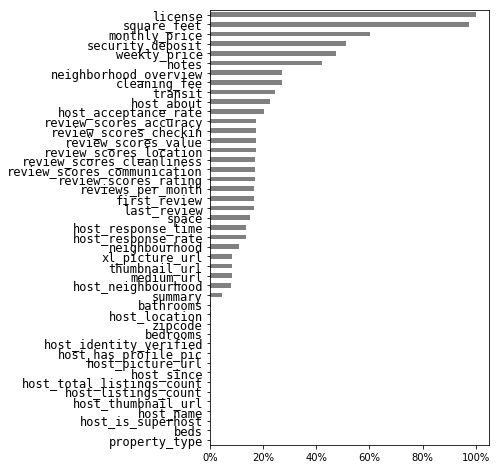

In [9]:
missing_count = (df.isnull().sum() / df.shape[0] * 100).sort_values()
missing_count = missing_count[missing_count != 0]
missing_count.plot(kind="barh", figsize=(5, 8), color="grey")
ax = plt.gca()

# close the inprosper spines
# for i in ["top", "right", "left"]:
#     ax.spines[i].set_visible(False)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, family="monospace")
# plt.title("Top 20 Developer Ratio In Different Country", loc="left", fontsize=20)

# set the xaxis format
formater = matplotlib.ticker.FormatStrFormatter("%0.f%%")
ax.xaxis.set_major_formatter(formater)

plt.show()

In [10]:
missing_count.sort_index()

bathrooms                        0.419068
bedrooms                         0.157150
beds                             0.026192
cleaning_fee                    26.977475
first_review                    16.422211
host_about                      22.498690
host_acceptance_rate            20.246202
host_has_profile_pic             0.052383
host_identity_verified           0.052383
host_is_superhost                0.052383
host_listings_count              0.052383
host_location                    0.209534
host_name                        0.052383
host_neighbourhood               7.857517
host_picture_url                 0.052383
host_response_rate              13.698271
host_response_time              13.698271
host_since                       0.052383
host_thumbnail_url               0.052383
host_total_listings_count        0.052383
last_review                     16.422211
license                        100.000000
medium_url                       8.381351
monthly_price                   60

In [11]:
display.display_html(
    "<p style='font: italic 25px Fira Sans, serif;'> \
        Missing value information: \
        <ul style='font: italic 25px Fira Sans, serif;'> \
            <li>There are {} fields that have missing values</li> \
            <li>The {} fields own missing value percentage is over 90%</li> \
        </ul>\
    </p>".format(len(missing_count), (missing_count > 90).sum()), 
    raw=True
)

Missing value information: There are 45 fields that have missing values The 2 fields own missing value percentage is over 90%

In [12]:
# convert the datatype as timestamp
columns = [
    "first_review",
    "last_review",
    "host_since",
    "calendar_last_scraped",
    "last_scraped"
]

preprocess.converted_time(df, columns, True)

In [13]:
# drop the fields own high missing value percentage
df.drop(missing_count[missing_count > 90].index, inplace=True, axis=1)

In [14]:
# the data point own host information is invalidate
df.loc[df[df.host_identity_verified.isnull()].index, df.columns[df.columns.str.contains("host")]]

,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count
1297,42515980,https://www.airbnb.com/users/show/42515980,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1
1419,1075031,https://www.airbnb.com/users/show/1075031,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,1


In [15]:
df.drop(df[df.host_identity_verified.isnull()].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
# extra the price and the cleaning_fee values from string
columns = [
    "price",
    "weekly_price",
    "monthly_price",
    "cleaning_fee",
    "security_deposit",
    "extra_people"
]

preprocess.money_columns(df, columns, True)

In [17]:
# replace the invalidate identifier in host_acceptance_rate
df["host_response_rate"] = df["host_response_rate"].str.replace("%", "").astype("float16")
df["host_acceptance_rate"] = df["host_acceptance_rate"].str.replace("%", "").astype("float16")

In [18]:
# replace the invalidate identifier in host_verifications
df["host_verifications"] = df["host_verifications"].str.replace("\[\]", "0")
df["host_verifications"] = df["host_verifications"].str.replace("\[|\]", "")
df.loc[:, "host_verifications"] = np.where(df["host_verifications"] == "0", np.repeat(np.nan, df.shape[0]), df.host_verifications)

In [19]:
# replace the invalidate identifier in amenities
df.loc[:, "amenities"] = df.amenities.str.replace("\{\}", "0")
df.loc[:, "amenities"] = df.amenities.str.replace('\{|\}|"', "")
df.loc[:, "amenities"] = np.where(df.amenities == "0", np.repeat(np.nan, df.shape[0]), df.amenities)

In [20]:
# https://www.airbnb.cn/help/article/828/what-is-a-superhost?ibbe=0
# convert the values which are boolean
columns = [
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "has_availability",
    "requires_license",
    "instant_bookable",
    "is_location_exact",
    "host_is_superhost", 
    "host_has_profile_pic",
    "host_identity_verified"
]

df.loc[:, columns] = df.loc[:, columns].applymap(lambda x: True if x == "t" else False if x=="f" else x)

#### Fix Timestamp Dtype
There are some object fields wrong dtype, because those dtype should be timestamp

#### Drop Invalidate Data Point
Because the host information are all invalidate, it is not appropriate to analysis information. So I think that the fields need be droped

#### Fix Wrong Idenifier
The fields about the money own \$ identfier, thounds seperate identifier, percentage identifier, which are wrong format. Besides, host_verifications contains \[ and \]. The field amenities own the identifier \{ and \}

#### Parse Boolean Dtypes From Object
The fields like require_guest_profile_picture, require_guest_phone_verification, has_availability, requires_license, instant_bookable, is_location_exact, host_is_superhost,  host_has_profile_pic, host_identity_verified are object, but value is boolean. So convert the values.

In [21]:
missing_category_count = df.select_dtypes("object").isnull().sum()
missing_category = missing_category_count.index[missing_category_count > 0]
print("There are not missing value fields:\n ")
df.select_dtypes("object").columns.difference(missing_category)

There are not missing value fields:
 


Index(['bed_type', 'calendar_updated', 'cancellation_policy', 'city',
       'country', 'country_code', 'description', 'experiences_offered',
       'host_name', 'host_picture_url', 'host_thumbnail_url', 'host_url',
       'jurisdiction_names', 'listing_url', 'market', 'name',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'picture_url',
       'room_type', 'smart_location', 'state', 'street'],
      dtype='object')

In [22]:
missing_category

Index(['summary', 'space', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_location',
       'host_about', 'host_response_time', 'host_neighbourhood',
       'host_verifications', 'neighbourhood', 'zipcode', 'property_type',
       'amenities'],
      dtype='object')

In [23]:
df.room_type.value_counts(dropna=False).sort_index()#.sort_values()

Entire home/apt    2539
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [24]:
df.loc[:, "zipcode"].replace("99\n98122", "98122", inplace=True)

In [25]:
from imp import reload
reload(preprocess)

<module 'preprocess' from '../tool/preprocess.py'>

In [27]:
def predict_category(
    data, columns, target_columns, algorithm, params, silence=True, cv=2, 
    inplace=True):
    """predict the missing value in target_columns

    Parameters:
        data: dataframe
            original data
        columns: list
            List contains column those will be used to predict value
        target_columns: string or list
            Need to be predicted missing value in the column
        algorithm: objects about algorithm
            List contains algorithm that will be used to train the model,
            and predict the missing value
        params: dict
            It is used to search the best parameters by gridsearchcv
        cv: int
            It is uded to a parameter in GridSearchCV
        inplace: boolean default True
            If True, fill in place. 
    Results:
        DataFrame, or Series
            target_columns value
    """
    result = pd.DataFrame()
    if slice:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if isinstance(target_columns, str):
                result[target_columns] = preprocess._predict_category_value(
                    data, columns, target_columns, algorithm, params, cv
                )
            elif isinstance(target_columns, list):
                for target_column in target_columns:
                    result[target_column] = preprocess._predict_category_value(
                        data, columns, target_column, algorithm, params, cv
                    )
    else:
        if isinstance(target_columns, str):
            result[target_columns] = preprocess._predict_category_value(
                data, columns, target_columns, algorithm, params, cv
            )
        elif isinstance(target_columns, list):
            for target_column in target_columns:
                result[target_column] = preprocess._predict_category_value(
                    data, columns, target_column, algorithm, params, cv
                )

    if inplace:
        data[target_columns] = result[target_columns]
        return
    else:
        return result

In [29]:
columns = [
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "longitude",
    "latitude"
]
algorithom = RandomForestClassifier(random_state=42)
params = {'criterion': ['gini', 'entropy'],
                  'n_estimators': [5, 9, 14],
                  'max_depth': [9, 12, 20, 25],
                  'min_samples_leaf':[2,4],
                  'min_samples_split': [20,30,40]}
# predict zipcode
predict_category(df, columns, "zipcode", algorithom, params, cv=6)


# convert the dtype as category
df["zipcode"] = df["zipcode"].astype("category")

The best estimater is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
The best f_0.5 score is 91.9093%
The test f_0.5 score is 92.6509%


In [30]:
columns = [
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "longitude",
    "latitude",
    "zipcode",
    "price",
]
# predict the neighbourhood, host_neighbourhood
target_columns = ["neighbourhood", "host_neighbourhood"]

predict_category(df, columns, target_columns, algorithom, params, cv=6)

The best estimater is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
The best f_0.5 score is 91.8400%
The test f_0.5 score is 92.3529%
The best estimater is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
The best f_0.5 score is 84.2280%
The test f_0.5 score is 83.6648%


In [31]:
columns = [
    "neighbourhood_cleansed",
    "longitude",
    "latitude",
    "price",
    "room_type",
]

# predict the property_type
predict_category(df, columns, "property_type", algorithom, params, cv=6)

The best estimater is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
The best f_0.5 score is 71.4666%
The test f_0.5 score is 71.5596%


#### Fix Category Dtype Fileds Missing Value

1. zipcode

    Because zipcode is relate with geographical information and neighbour information, I use the fields to predict the missing value. Besides, the zipcode value "99\n98122" must be fix a validate value. Finally, I convert the dtype as category
    
2. neighbourhood and host_neighbourhood
    
    The neighbourhood values can be parsed from some another fields, like geographical information, zipcode, rental price and others neighbour information
    
3. property_type
    
    The property_type values stands for the hosts's block type, there is one missing value. Using the location information, rental price, and host status to parse the missing value

In [32]:
# count the amenities amount
df["amenities_total"] = df.amenities.apply(lambda x: 0 if pd.isnull(x) else len(x.split(",")) + 1)

In [33]:
# parse whether the host_location is seattle
df["host_seattle"] = df.host_location.str.contains("Seattle|seattle")
df["host_seattle"].fillna(False, inplace=True)

In [34]:
# parse the host_verifications amount
df["host_verifications_total"] = df.host_verifications.apply(lambda x: 0 if pd.isnull(x) else len(x.split(",")) + 1)

In [35]:
# parse the host operate period
df["host_since_period"] = (df["calendar_last_scraped"] - df["host_since"]).dt.days

#### Parse Information From Fields

1. amenities

    There are many amenities provided by the hosts, so the amount of amenities maybe are useful. Parse the amenities information as amenities_total
    
2. host_location

    The field can interpret whether the host is at seattle, so parse the field into host_seattle
    
3. host_verifications
    
    There are various verifications option about the hosts, so the amount of the host verifications are useful. Parse the host_verfifications as host_verifications_total
    
4. host_since, and calendar_last_scraped

    The two fields can be used to interpret the hosts operate period, that new field is host_since_peroid


In [36]:
df.loc[df[['bathrooms', 'bedrooms', 'beds']].isnull().any(axis=1), ['bathrooms', 'bedrooms', 'beds']]

,bathrooms,bedrooms,beds
1242,NaN,1.0,2.0
1313,NaN,1.0,2.0
1356,NaN,2.0,3.0
1377,NaN,1.0,1.0
1427,1.0,NaN,1.0
1490,1.0,NaN,1.0
1491,1.0,NaN,2.0
1851,1.0,NaN,1.0
1959,NaN,1.0,NaN
1973,NaN,1.0,1.0


In [37]:
# fill the missing value in bathrooms, bedrooms, beds with 0
df.loc[:,['bathrooms', 'bedrooms', 'beds']] = df.loc[:,['bathrooms', 'bedrooms', 'beds']].fillna(0,axis=0)

In [38]:
# convert the price fields values
df.loc[:, "weekly_price"] = np.where(df.weekly_price.isnull(), df["price"] * 7, df["weekly_price"])
df.loc[:, "monthly_price"] = np.where(df.monthly_price.isnull(), df["price"] * 30, df["monthly_price"])

In [41]:
def predict_numerical_value(
    data, columns, pred_column, algo, params, cv=2, pca_components=None, 
    metrics_func=None
):
    """predict the missing value in pred_column

    Parameters:
        data: dataframe
            original data
        columns: list
            List contains column those will be used to predict value
        pred_column: string
            Need to be predicted missing value in the column
        algo: objects about algorithm
            List contains algorithm that will be used to train the model,
            and predict the missing value
        params: dict
            It is used to search the best parameters by gridsearchcv
        cv: int
            It is uded to a parameter in GridSearchCV
        pca_compnents: int default None
            If it is a validate int number, there is a pca decomposition step
        metircs_func: Callable default None
            Use another metrics to measure the model, if it exists
    Results:
        pred_column value
    """
    data = data.copy()
    new_data, new_columns, index_missing, index_train = preprocess.dummy_variables(
        data, columns, pred_column
    )
    
    train_X, test_X, train_y, test_y = train_test_split(
        new_data.loc[index_train, new_columns], new_data.loc[index_train, pred_column], 
        test_size=0.2, random_state=42
    )
    predict_X = new_data.loc[index_missing, new_columns]

    if pca_components:
        pca = PCA(n_components=pca_components)
        pca.fit(train_X)
        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)
        predict_X = pca.transform(predict_X)

        print("After decomposition with {} components PCA.".format(pca_components))


    # make the score metrics, basic metrics is r2 and mse
    score = {
         "mse": make_scorer(mean_squared_error, greater_is_better=False),
        "r2": make_scorer(r2_score, greater_is_better=True) 
    }

    if metrics_func:
        for key, value in metrics_func:
            score[key] = value
    
    if params:
        algorithm = GridSearchCV(
            algo, param_grid=params, scoring=score, iid=False, cv=cv, refit="mse"
        )
    else:
        algorithm = algo
    
    algorithm.fit(train_X, train_y)
    print("The train data r2 score is {:0.4f}.\nTest mse score is {:0.4f}. ".format(
        r2_score(train_y, algorithm.predict(train_X)), 
        mean_squared_error(test_y, algorithm.predict(test_X)))
    )
    
    y_missing = algorithm.predict(predict_X)
    data.loc[index_missing, pred_column] = y_missing
    
    return data.loc[:, pred_column]

In [44]:
# predict the numerical value about review_scores_rating, reviews_per_month, cleaning_fee
pred_columns = ["review_scores_rating", "reviews_per_month", "cleaning_fee"]
pred_result = dict()

columns = [
    'host_identity_verified',
    'availability_365',
    'longitude',
    'latitude',
    'amenities_total',
    'number_of_reviews',
    'price',
    'maximum_nights',
    'minimum_nights',
    'host_is_superhost',
]

pca_components = 10

params = {'criterion': ['mse', 'mae'],
                  'n_estimators': [10, 14, 20],
                  'max_depth': [16, 20, 25, 30],
                  'min_samples_leaf':[2,4],
                  'min_samples_split': [20,30,40]}

# store predict result
pred_result = dict()
for pred_column in pred_columns:
    algorithm = RandomForestRegressor(random_state=42, n_jobs=4)
    pred_result[pred_column] = predict_numerical_value(df, columns, pred_column, algorithm, params)

The train data r2 score is 0.3247.
Test mse score is 44.7566. 
The train data r2 score is 0.7312.
Test mse score is 1.5894. 
The train data r2 score is 0.7281.
Test mse score is 1121.3500. 


In [46]:
# fill the missing value
pred_columns = ["reviews_per_month", "cleaning_fee"]
for column in pred_columns:
    df.loc[df[column].isnull(), column] = pred_result[column]

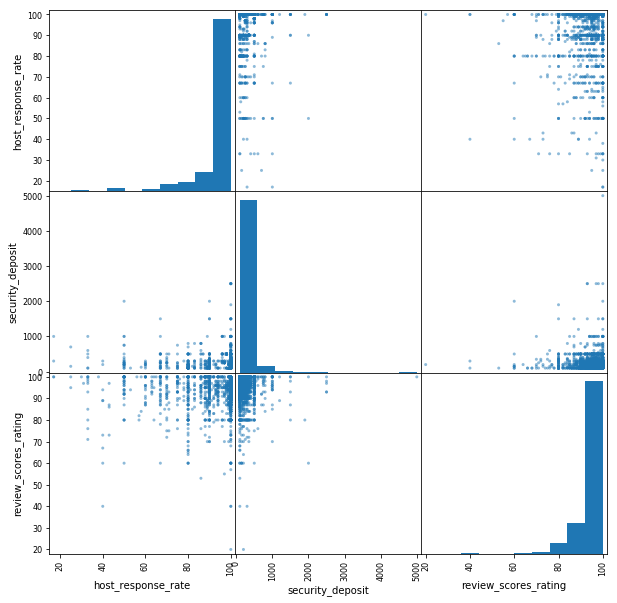

In [47]:
pd.plotting.scatter_matrix(df[["host_response_rate", "security_deposit","review_scores_rating"]],
                           figsize=(10, 10))
plt.show()

In [48]:
df["security_deposit"].fillna(0, inplace=True)

df.loc[:, ["host_response_rate","review_scores_rating"]] = \
    df[["host_response_rate","review_scores_rating"]].fillna(
        df[["host_response_rate","review_scores_rating"]].median()
    )

#### Fix Number Dtype Fileds With Missing Value

1. bathrooms, bedrooms, and beds
    
    The three fields just count the accomadations information. Besides, there are not missing values about the bedrooms and the beds at the same time. So fill the missing values by 0

2. weekly_price and monthly_price

    Most of the number dtype fields are skewed. There are some fields values parsed from other fields, like monthly_price and weekly_price

3. reviews_per_month, and cleaning_fee

    Use the machine learning method to predict the missing value about the fields reviews_per_month, cleaning_fee, and review_score_rating. But score of fitting review_score_rating is so poor, use another strategy to predict the missing value.

4. security_deposit

    The field is right skewness. In the reality, maybe there are not security_deposit demanded by the hosts, so fill the missing value with 0
    
5. host_response_rate, and review_scores_rating

    The two fields are skewness too, and they are about reviewing. Use the median value to fill in missing value

<a id="model"></a>
## Data Model

After accessing data information, and visualizing data(the file is [Visualization](./Visualization.ipynb)), we found some useful information:

1. The House type maybe is a traveler's prior choice
2. Set the three level amenities
        
   - The average price difference of the highest level amenities is lower than the lowest level, but there is negative value about the lowest level
        
   - The same level amenities served by the hosts are very close, but the same level amenities non-served by the hosts are apparently different
        
   - There is a special amenity, Doorman. Because its average difference price is the highest, and it is the lowest level amenity. I suspect that the amenity is served by the high-end hosts
   

Through the steps, the data is tidy. We will answer the posted questions that **What do Promote Travelers' Accommodation Reservation** by using model.Right now, we want to dive into deep discussion that how the another facters push the travelers. In order to measuer the the the travelers' accommadation arrangement we use the other label as the second target variable, the total reviews.

There are so many factors affecting the travelers' choice, like price, circumstance, amenities, review context, and so on. At the same time, we can know the reversation result by the total review. Finally, we choose two label the total review to analyze the factor.

### Evaluation Metrics
The model is created as supervised machine learning, regression model. The mean squared error and r2 score to measure the model validation. After the model training, we will use the other metric to measure the final score, root mean square percentage error that is robost

### Feature Engineer


In [49]:
drop_columns = [
    "thumbnail_url",
    "id",
    "listing_url",
    "scrape_id",
    "last_scraped",
    "name",
    "summary",
    "space",
    "description",
    "experiences_offered",
    "neighborhood_overview",
    "notes",
    "transit",
    "medium_url",
    "picture_url",
    "xl_picture_url",
    "host_url",
    "host_name",
    "host_location",
    "host_about",
    "host_response_time",
    "host_acceptance_rate",
    "host_thumbnail_url",
    "host_picture_url",
    "host_listings_count",
    "host_verifications",
    "host_has_profile_pic",
    "street",
    "neighbourhood",
    "neighbourhood_cleansed",
    "city",
    "state",
    "market",
    "smart_location",
    "country_code",
    "country",
    "calendar_updated",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "requires_license",
    "jurisdiction_names",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
    "calculated_host_listings_count",
    "availability_30",
    "availability_60",
    "availability_90",
    "host_neighbourhood"
]

In [50]:
data = df.drop(drop_columns, axis=1).copy()

In [51]:
data.isnull().sum().loc[data.columns[data.isnull().sum() !=0]]

amenities        45
first_review    625
last_review     625
dtype: int64

In [52]:
# parse the review days
data["start_review"] = (data["first_review"] - data["host_since"]).dt.days
data["latest_review"] = (data["calendar_last_scraped"] - data["last_review"]).dt.days

In [53]:
data.loc[(data["start_review"] < 0) | (data.start_review.isnull()),
         ["first_review", "host_since", "start_review"]].sample(20)

,first_review,host_since,start_review
1741,NaT,2013-04-29,NaN
3061,NaT,2011-06-28,NaN
3450,NaT,2014-03-02,NaN
1652,NaT,2013-08-30,NaN
3371,NaT,2011-03-08,NaN
3381,NaT,2015-11-02,NaN
2218,NaT,2015-10-13,NaN
1063,NaT,2015-12-04,NaN
1470,NaT,2011-03-08,NaN
1623,NaT,2014-05-19,NaN


In [54]:
# fill missing value
data[['start_review', 'latest_review']] = \
    data[['start_review', 'latest_review']].fillna(0)

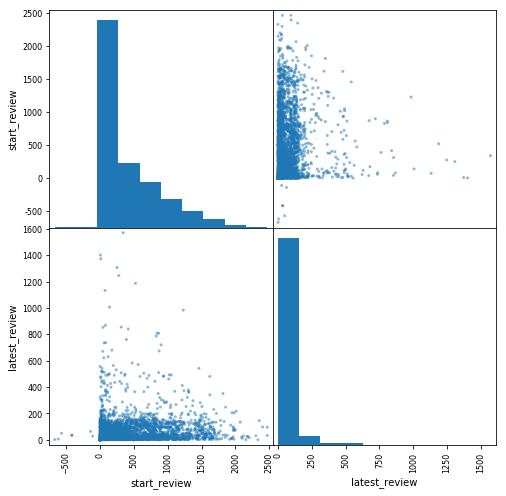

In [55]:
pd.plotting.scatter_matrix(data[["start_review", "latest_review"]], figsize=(8, 8));

In [56]:
amenities_set = set()
for i in df.amenities:
    if pd.notnull(i):
        amenities_set |= set(i.split(","))

# remove the element Internet
amenities_set.remove("Internet")

In [57]:
# parse the amenity 
for amenity in amenities_set:
    data["amenity_availible_" + amenity] = \
        data["amenities"].apply(
            lambda x: False if pd.isnull(x) else True if amenity in x else False
        )
    

#### Parse Extra information
As we see the information about the fields chosen, there are some information need to be parsed, like amenities and the review date

1. caculate how many daies between the hosts start and the first review date, and caculate how many daies between the latest review and the scraped date. But there are some negative values about the start_review, which is unreasonable. The field start review need to delete
2. parse the amenities information from the amenities field
3. there are some category object left that need to parse

In [58]:
data["host_id"] = data["host_id"].astype("category")

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816 entries, 0 to 3815
Data columns (total 84 columns):
host_id                                         3816 non-null category
host_since                                      3816 non-null datetime64[ns]
host_response_rate                              3816 non-null float16
host_is_superhost                               3816 non-null bool
host_total_listings_count                       3816 non-null float64
host_identity_verified                          3816 non-null bool
neighbourhood_group_cleansed                    3816 non-null object
zipcode                                         3816 non-null category
latitude                                        3816 non-null float64
longitude                                       3816 non-null float64
is_location_exact                               3816 non-null bool
property_type                                   3816 non-null object
room_type                                       3816 no

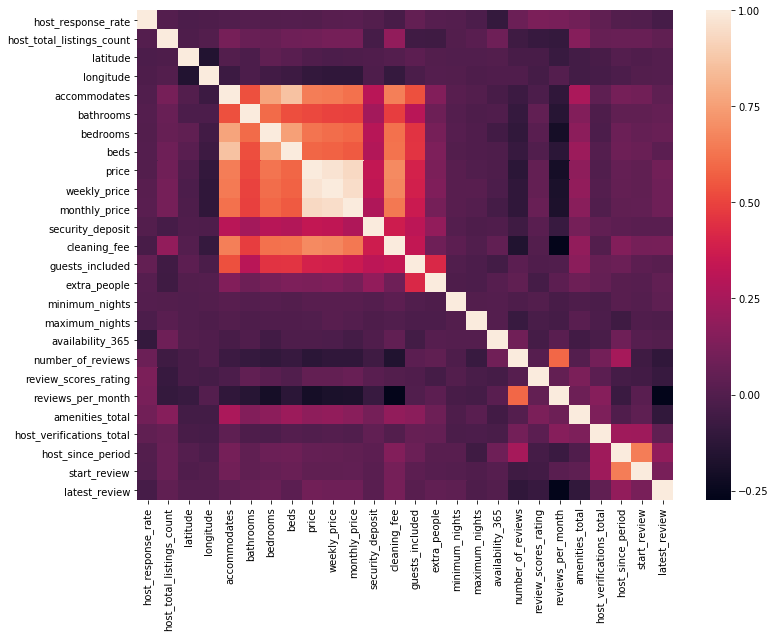

In [60]:
plt.figure(figsize=(12, 9))
ax = plt.subplot()
sns.heatmap(data.select_dtypes("number").corr(), ax=ax)
ax.tick_params(axis="x", labelrotation=90)

According to the heatmap plot, there are some field high relationship, like price, weekly_price, monthly_price, accommodates, cleaning_fee. So create some new features to select.Now we need delete the category fields and drop unnecessary fields.

Next step, we'll use the **SelectPercentile** method to select the top 30 features to create model. And to measure the model generalization, split some data into test dataset.

In [61]:
data["price_per_accomodate"] = data["accommodates"] / data["price"]
data["all_beds"] = data[["beds", "bedrooms"]].sum(axis=1)

In [62]:
object_columns = ["neighbourhood_group_cleansed", "property_type", "room_type", "bed_type", "cancellation_policy"]
data = pd.concat([data, preprocess.dummy_variables(data, object_columns)[0]], axis=1)

In [63]:
# drop the category fields
data.drop(data.select_dtypes("object").columns, axis=1, inplace=True)

In [64]:
data.drop(
    ["weekly_price", "monthly_price", "beds", "bedrooms", "host_id",
     "accommodates", "first_review", "host_since", "instant_bookable",
     "calendar_last_scraped", "last_review", "has_availability", "start_review"],
    axis=1, inplace=True
)

In [65]:
# select the fields
features = SelectPercentile(f_regression, percentile=30)
data_selected = features.fit_transform(data.drop("number_of_reviews", axis=1), data["number_of_reviews"])


In [66]:
feature_result = dict()
for key, value in zip(data.columns, features.scores_):
    feature_result[key] = value
    feature_result = pd.Series(feature_result, name="feature_select_score")
#     feature_result.append((key, value))
    
# feature_result = pd.DataFrame(feature_result, columns=["feature", "score"])

In [67]:
important_feature_result = feature_result[feature_result > feature_result.quantile(0.7)]

In [68]:
important_feature_result.sort_values(ascending=False)

review_scores_rating                      2109.213777
host_is_superhost                          280.694072
host_verifications_total                   262.030707
cleaning_fee                               105.301396
amenity_availible_Other pet(s)              78.193919
property_type_Bungalow                      74.774088
bed_type_Real Bed                           65.734560
price                                       60.125481
amenities_total                             57.755448
is_location_exact                           50.484456
host_since_period                           48.729683
price_per_accomodate                        41.215697
host_seattle                                41.209981
amenity_availible_Dog(s)                    39.542306
host_identity_verified                      36.371498
bathrooms                                   34.510116
availability_365                            33.899093
maximum_nights                              25.583042
amenity_availible_Air Condit

In [69]:
from imp import reload
reload(preprocess)

<module 'preprocess' from '../tool/preprocess.py'>

In [70]:
# use kfold to measure linear model repeatly
lm = LinearRegression()
ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

lm_score = []

for train_index, test_index in ss.split(data):
    train_X = data_selected[train_index, :]
    test_X = data_selected[test_index, :]
    train_y = data["number_of_reviews"][train_index]
    test_y = data["number_of_reviews"][test_index]
    
    lm.fit(train_X, train_y)
    
    lm_score.append((lm.score(test_X, test_y), mean_squared_error(test_y, lm.predict(test_X))))


lm_score = pd.DataFrame(lm_score, columns=["r2", "mse"])

In [71]:
display.display_html(
    "<p style='font: italic 25px Fira Sans, serif;'> \
        <em>About the reviews:</em> \
        Basic LinearRegression r^2 score is {:.2f}. The mean squared error is {:.2f} \
     </p>".format(lm_score.r2.mean(), lm_score.mse.mean()),
    raw=True
)


About the reviews: Basic LinearRegression r^2 score is 0.35. The mean squared error is 965.74

#### BenchMark--Basic LinearRegression
We want to know what is effect, when we use model tuning. So we need to create the benchmark that is linear model. The basic linear regression result is not perfet, the $R^2$ score is 0.34, and MSE score is 984.86. Now, we use the DecisionTree to create the regresssion model, so that we can analyse the importance of the features.

In [72]:
# split the dataset
train_X, test_X, train_y, test_y = \
    train_test_split(
        data_selected, data["number_of_reviews"], 
        test_size=0.3, random_state=42, 
)

In [73]:
forest_reg = RandomForestRegressor(random_state=42, n_jobs=4)

# search params
parameters = {'criterion': ['gini', 'entropy'],
              'n_estimators': [5, 10, 15, 20],
              'max_depth': [8, 14, 20, 25, 50],
              'min_samples_leaf':[2,4],
              'min_samples_split': [20,30,40]}
# make scoring
score = {
     "mse": make_scorer(mean_squared_error, greater_is_better=False),
    "r2": make_scorer(r2_score, greater_is_better=True) 
}

forest_reg = GridSearchCV(
        forest_reg, param_grid=params, scoring=score, iid=False, cv=2, refit="mse"
    )

# fit the data
forest_reg.fit(train_X, train_y)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'criterion': ['mse', 'mae'], 'n_estimators': [10, 14, 20], 'max_depth': [16, 20, 25, 30], 'min_samples_leaf': [2, 4], 'min_samples_split': [20, 30, 40]},
       pre_dispatch='2*n_jobs', refit='mse', return_train_score='warn',
       scoring={'mse': make_scorer(mean_squared_error, greater_is_better=False), 'r2': make_scorer(r2_score)},
       verbose=0)

In [74]:
r2_score(train_y, forest_reg.predict(train_X)), mean_squared_error(train_y, forest_reg.predict(train_X))

(0.7227358971322075, 393.9075701984275)

In [75]:
# pred_result = forest_reg.predict(tess)

display.display_html(
    "<p style='font: italic 25px Fira Sans, serif;'> \
        Decision Tree model,  r^2 score is {:.2f}. The mean squared error is {:.2f} \
     </p>".format(r2_score(test_y, forest_reg.predict(test_X)), 
    mean_squared_error(test_y, forest_reg.predict(test_X))),
    raw=True
)


Decision Tree model, r^2 score is 0.62. The mean squared error is 544.91

In [76]:
forest_reg.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

#### DecisionTree Model
As shown before, basic linear regresssion is not perfect. The regression can't fit the data well, and the MSE value is high. The next step is use decision tree to create model. Besides, we use **GridSearchCV** to tuning the model.We get the best estimetor is 

```
RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
```

Now, we'll analyse the feature importance result

In [77]:
feature_reg_result = dict()
for key, value in zip(important_feature_result.index, forest_reg.best_estimator_.feature_importances_):
    feature_reg_result[key] = value
    feature_reg_result = pd.Series(feature_reg_result, name="forest_score").sort_values(ascending=False)


In [78]:
feature_report = pd.concat([important_feature_result, feature_reg_result], axis=1, sort=False, )
feature_report.reset_index(inplace=True)
feature_report.rename({"index":"feature"}, inplace=True, axis=1)
# feature_report["forest_score"] = feature_report["forest_score"] * -1

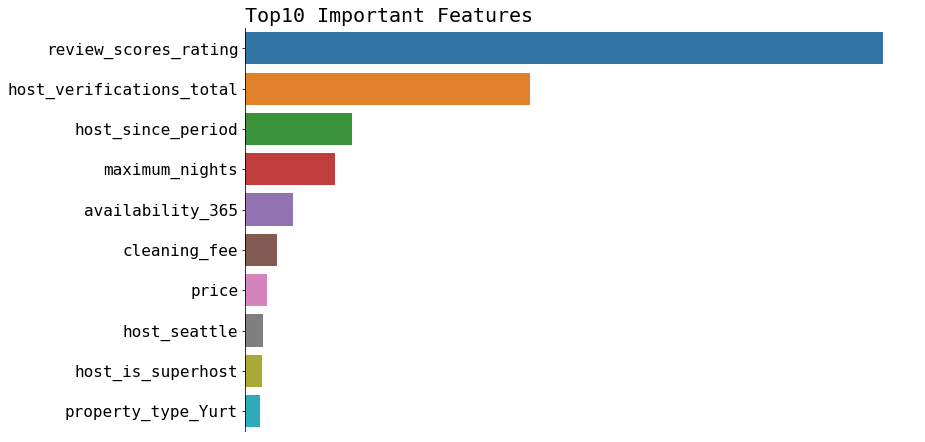

In [79]:
# feature importance
plt.figure(figsize=(12, 12*0.618))
ax = plt.subplot()
sns.barplot(y="feature", x="forest_score", data=feature_report.nlargest(10, "forest_score"), ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Top10 Important Features", loc="left", fontsize=20, family="monospace")
ax.tick_params(axis="y", labelsize=16)
ax.set_yticklabels(ax.get_yticklabels(), family="monospace")
ax.set_xticks([])

for spine in ["top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
plt.show()

In [80]:
data.columns[data.columns.str.contains("property_type")]

Index(['property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt'],
      dtype='object')

In [81]:
df.property_type.unique()

array(['Apartment', 'House', 'Cabin', 'Condominium', 'Camper/RV',
       'Bungalow', 'Townhouse', 'Loft', 'Boat', 'Bed & Breakfast',
       'Other', 'Dorm', 'Treehouse', 'Yurt', 'Chalet', 'Tent'],
      dtype=object)

After training the decision tree model, we get the new $R^2$ score 0.62, MSE score 548.61. The new model is better than basic linear model. Now we can analyse the important features. We choose the top 10 important features:

 - review_score_rating the rating rank concerns with the user experience. The high rating is, the more comfortable the house is. This is a clue when the travelers arrange the accommodation, the review_socre_rating is the prior factor
 - host_verification_total the feature is parsed from host_verification that contains a different type of the hosts' verification
 - host_since_period the feature is parsed from host_since. It can specify that how long the hosts run the business. The feature and host_verification_total can reflect that whether the hosts are professional
 - maximum_nights the feature is high relative to the travelers' arrangement. Of course, I recommend that put it into the factor
 
Other factors need to be taken into account, like cleaning_fee, price, and host_is_superhost. One is concerned with the fee, the other is a certification by the Airbnb.